## GENERATING ML AND DL MODELS
Using the cleaned churn modelling data, I will create and test multiple models.
All the models are designed to solve classification problem, and model hyper-
parameters are optimized using Grid Search and cross-validation with k=10.
With 10k samples, each cross-validation set has 1k entries, and therefore
the data is not likely to be sparse.

### NOTE
The continuous features are scaled using standard scaler and therefore will be
used directly. The categorical features Gender and Geography have to be encoded.
One hot encoding with dropping the first value is the preferred method. This is 
chosen as the number of samples >> number of parameters even after one hot encoding 
is performed.

In [77]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [78]:
# reading the dataframe
dataset = pd.read_csv("Churn_Modelling_cleaned.csv")
print(dataset.isna().sum())

Geography          0
Gender             0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
Exited             0
CreditScore        0
Age                0
Tenure             0
Balance            0
EstimatedSalary    0
dtype: int64


As seen from the above, there are no missing values. Proceeding with one hot encoding

In [79]:
# one hot encoding using pd.get_dummies
encoding_cols = ["Gender", "Geography"]
encoded_df = pd.get_dummies(dataset, columns=encoding_cols, drop_first=True)
print(encoded_df.head())

   NumOfProducts  HasCrCard  IsActiveMember  Exited  CreditScore       Age  \
0              1          1               1       1    -0.326221  0.293517   
1              1          0               1       0    -0.440036  0.198164   
2              3          1               0       1    -1.536794  0.293517   
3              2          0               0       0     0.501521  0.007457   
4              1          1               1       0     2.063884  0.388871   

     Tenure   Balance  EstimatedSalary  Gender_Male  Geography_Germany  \
0 -1.041760 -1.225848         0.021886            0                  0   
1 -1.387538  0.117350         0.216534            0                  0   
2  1.032908  1.333053         0.240687            0                  0   
3 -1.387538 -1.225848        -0.108918            0                  0   
4 -1.041760  0.785728        -0.365276            0                  0   

   Geography_Spain  
0                0  
1                1  
2                0  
3 

Dataset is ready for use. Starting the predictions.

In [80]:
# train test split
# as we expect class imbalance (exited_0 = 79.6%), stratified sampling is used
# based on y (the output variable)
from sklearn.model_selection import train_test_split
X = encoded_df.drop("Exited", axis=1)
y = encoded_df["Exited"]
xtrain,xtest, ytrain, ytest = train_test_split(X,y, test_size=0.25,random_state=1987, stratify=y)

print(xtrain.shape, xtest.shape)


(7500, 11) (2500, 11)


We shall use the same train test data for all classification models.
That way, we can compare the performance of each model.

In [81]:
# defining metrics dataframe
performance_metrics = pd.DataFrame(data=None, columns=["Model", "precision", "recall", "f1_score", "accuracy", "Log Loss"])

model_names = []
precison_vals = []
recall_vals = []
f1_vals = []
accuracy_vals = []
log_loss_vals = []

We are going to use the best model based on grid search cv and cross validation.
Therefore performance of only one instance per model is finally recorded.

In [82]:
# model performance function
# as all models are based on classification, I am using the below function
# for easing the model performance
from sklearn.metrics import precision_score, log_loss, recall_score, f1_score, accuracy_score

def modelEvaluator(model, model_name, x_test, y_test):
  y_pred = model.predict(x_test)
  precision = precision_score(y_true=y_test, y_pred = y_pred)
  recall = recall_score(y_true=y_test, y_pred = y_pred)
  f1 = f1_score(y_true=y_test, y_pred = y_pred)
  accuracy = accuracy_score(y_true=y_test, y_pred = y_pred)
  logloss = log_loss(y_true=y_test, y_pred = y_pred)
  model_names.append(model_name)
  precison_vals.append(precision)
  recall_vals.append(recall)
  f1_vals.append(f1)
  accuracy_vals.append(accuracy)
  log_loss_vals.append(logloss)

### LOGISTIC REGRESSION

In [83]:
# running a logistic regression
# elastic net and corresponding solver is chosen
#
from sklearn.linear_model import LogisticRegressionCV
l1_values = [0.4,0.6,0.8,0.9] # ratio of L1-L2 regularisation, more value gives more weight to L1
lgregressor = LogisticRegressionCV(cv=10, fit_intercept=True, n_jobs=-1,penalty='elasticnet',
                                   solver='saga', verbose=1, l1_ratios=l1_values, random_state=1987)
lgregressor.fit(xtrain, ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
rescaling...
convergence after 1 epochs took 0 seconds
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds
rescaling...
r

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


LogisticRegressionCV(cv=10, l1_ratios=[0.4, 0.6, 0.8, 0.9], n_jobs=-1,
                     penalty='elasticnet', random_state=1987, solver='saga',
                     verbose=1)

In [84]:

modelEvaluator(model=lgregressor, x_test=xtest, y_test=ytest, model_name="Logisitc Regression")


In [85]:
# Using Grid search for hyper-param tuning
from sklearn.model_selection import GridSearchCV

### Decision Tree

For decision tree, we aim to perform hyper-parameter tuning. Specifically two different measures of impurity are used and best model is selected based on accuracy (categorcial agreement), f1 score and recall (improving sensitivity of the model).
Sensitivity is chosen as a metric for cross validation as the objective is to minimize exitors (therefore a misclassification as non-exitor is more penalised).

In [86]:
from sklearn.tree import DecisionTreeClassifier
params = {"criterion": ["gini", "log_loss"], "min_impurity_decrease": [0, 0.01, 0.05]}
decision_tree = DecisionTreeClassifier(splitter='best', random_state=1987)
dt_search = GridSearchCV(estimator = decision_tree, param_grid=params, cv=10, 
                         scoring=["accuracy", "f1", "recall"], n_jobs=-1, refit="accuracy")
dt_search.fit(X=xtrain, y=ytrain)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1987),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'log_loss'],
                         'min_impurity_decrease': [0, 0.01, 0.05]},
             refit='accuracy', scoring=['accuracy', 'f1', 'recall'])

In [87]:
# get best params and run the tree search
print(f"The best estimator is: {dt_search.best_estimator_}")
print(f"The best score is: {dt_search.best_score_}")
print(f"The best params are: {dt_search.best_params_}")

The best estimator is: DecisionTreeClassifier(criterion='log_loss', min_impurity_decrease=0.01,
                       random_state=1987)
The best score is: 0.8445333333333334
The best params are: {'criterion': 'log_loss', 'min_impurity_decrease': 0.01}


In [88]:
best_tree = DecisionTreeClassifier(criterion="log_loss", min_impurity_decrease=0.01)
best_tree.fit(X=xtrain, y=ytrain)

DecisionTreeClassifier(criterion='log_loss', min_impurity_decrease=0.01)

[Text(0.4583333333333333, 0.875, 'x[4] <= 0.246\nlog_loss = 0.729\nsamples = 7500\nvalue = [5972, 1528]'),
 Text(0.25, 0.625, 'x[0] <= 2.5\nlog_loss = 0.5\nsamples = 5096\nvalue = [4536, 560]'),
 Text(0.16666666666666666, 0.375, 'x[0] <= 1.5\nlog_loss = 0.456\nsamples = 4988\nvalue = [4510, 478]'),
 Text(0.08333333333333333, 0.125, 'log_loss = 0.617\nsamples = 2452\nvalue = [2077, 375]'),
 Text(0.25, 0.125, 'log_loss = 0.245\nsamples = 2536\nvalue = [2433, 103]'),
 Text(0.3333333333333333, 0.375, 'log_loss = 0.796\nsamples = 108\nvalue = [26, 82]'),
 Text(0.6666666666666666, 0.625, 'x[2] <= 0.5\nlog_loss = 0.972\nsamples = 2404\nvalue = [1436, 968]'),
 Text(0.5, 0.375, 'x[4] <= 1.009\nlog_loss = 0.987\nsamples = 1093\nvalue = [473, 620]'),
 Text(0.4166666666666667, 0.125, 'log_loss = 0.985\nsamples = 719\nvalue = [411, 308]'),
 Text(0.5833333333333334, 0.125, 'log_loss = 0.648\nsamples = 374\nvalue = [62, 312]'),
 Text(0.8333333333333334, 0.375, 'x[0] <= 2.5\nlog_loss = 0.835\nsamples 

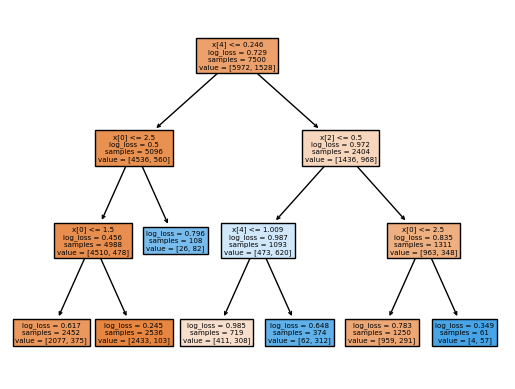

In [89]:
# viewing the decision tree
from sklearn.tree import plot_tree
plot_tree(decision_tree=best_tree, filled=True)

In [90]:
# metrics for DT
modelEvaluator(model=best_tree, x_test=xtest, y_test=ytest, model_name="Decision Tree")

### Random Forest classifier
For a random forest classifier, we shall use same params grid and number of trees to vary from 1000 - 25 (approx. half from the previous instance).


In [91]:
from sklearn.ensemble import RandomForestClassifier
params_rf = {"criterion": ["gini", "log_loss"], "min_impurity_decrease": [0, 0.01, 0.05],
          "n_estimators": [1000,500,250,100,50,25]}
rf_grid = RandomForestClassifier(random_state=1987)
rf_search = GridSearchCV(estimator = rf_grid, param_grid=params_rf, cv=10, 
                         scoring=["accuracy", "f1", "recall"], n_jobs=-1, refit="accuracy")

rf_search.fit(X=xtrain, y=ytrain)
# get best params and run the tree search
print(f"The best estimator is: {rf_search.best_estimator_}")
print(f"The best score is: {rf_search.best_score_}")
print(f"The best params are: {rf_search.best_params_}")


The best estimator is: RandomForestClassifier(min_impurity_decrease=0, n_estimators=500,
                       random_state=1987)
The best score is: 0.8637333333333335
The best params are: {'criterion': 'gini', 'min_impurity_decrease': 0, 'n_estimators': 500}


In [92]:
# creating best model with best params, and performing model evaluation
best_rf = RandomForestClassifier(random_state=1987, n_estimators=500, criterion="gini",
                                 min_impurity_decrease=0, n_jobs=-1)
best_rf.fit(X=xtrain, y=ytrain)
modelEvaluator(model=best_rf, x_test=xtest, y_test=ytest, model_name="Random Forest")

### Naive Bayes classifier
As the data has both categorical and continuous variables, and sklearn's NB classifier can accept only one form of varibales, NB classification is not performed right now. However, a mixed NB implementation is available at https://github.com/remykarem/mixed-naive-bayes
I may plan to use it at a later date.

### SVM classifier
Using all default params except for C

In [93]:
from sklearn.svm import SVC
params_svm = {"C": [1,5,10,15]}
svm_model = SVC(random_state=1987)
svm_grid = GridSearchCV(estimator=svm_model, param_grid=params_svm, verbose=1, cv=10, 
                        scoring=["accuracy", "f1", "recall"], n_jobs=-1, refit="accuracy")
svm_grid.fit(X=xtrain, y=ytrain)

print(f"The best estimator is: {svm_grid.best_estimator_}")
print(f"The best score is: {svm_grid.best_score_}")
print(f"The best params are: {svm_grid.best_params_}")


Fitting 10 folds for each of 4 candidates, totalling 40 fits
The best estimator is: SVC(C=5, random_state=1987)
The best score is: 0.8597333333333333
The best params are: {'C': 5}


In [94]:
# best model and its performance
best_svm = SVC(C=5, random_state=1987)
best_svm.fit(X=xtrain, y=ytrain)
modelEvaluator(model=best_svm, model_name="SVM", x_test=xtest, y_test=ytest)

In [95]:
print(f"{model_names}\n{accuracy_vals}\n{log_loss_vals}")
performance_metrics["model"] = model_names
performance_metrics["precision"] = precison_vals
performance_metrics["recall"] = recall_vals
performance_metrics["f1_score"] = f1_vals
performance_metrics["accuracy"] = accuracy_vals
performance_metrics["Log Loss"] = log_loss_vals

performance_metrics.to_csv("classification_metrics.csv", index=False)


['Logisitc Regression', 'Decision Tree', 'Random Forest', 'SVM']
[0.8092, 0.8304, 0.8584, 0.8512]
[6.877129066643553, 6.11300361479427, 5.103781319898988, 5.3632956243006324]
